# Neo eFEL example

This notebook shows an example on how to load electrophysiology data using Neo and extract eFeatures using eFEL.

In [1]:
import efel

import numpy
import json

%matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10

## Loading the data with Neo

We will use the voltage trace recordings obtained from a mouse thalamic cell classified as a bursting accommodating (bAC) etype. The data is stored in an NWB (Neurodata Without Borders) file, and we will use the [Python Neo](https://github.com/NeuralEnsemble/python-neo) library to load it.

In [ ]:
test_data = "../../tests/testdata/JY180308_A_1.nwb"
stim_start = 250
stim_end = 600
blocks = efel.io.load_neo_file(test_data, stim_start, stim_end)
traces = blocks[0][0]

Let's get a trace that includes an action potential

In [3]:
trace = traces[3]

In [4]:
time = trace['T']
voltage = trace['V']

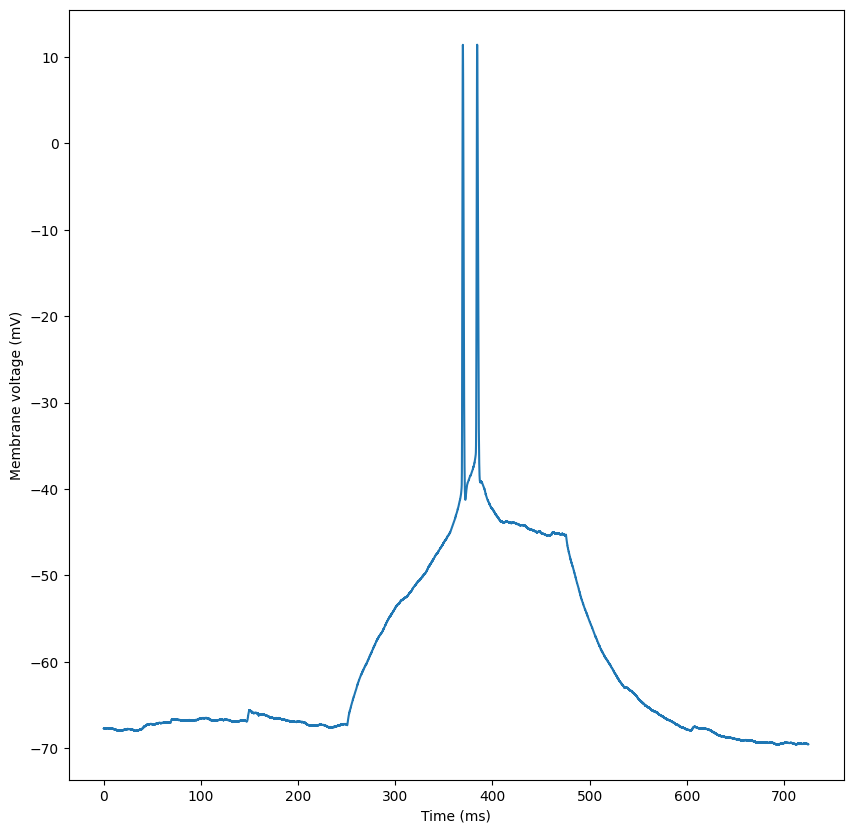

In [5]:
plt.rcParams['figure.figsize'] = 10, 10

fig1, ax1 = plt.subplots(1)
ax1.plot(time, voltage)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Membrane voltage (mV)');

## Extracting eFeatures with eFEL

We can now use the eFEL to extract eFeature values from the trace shown above.

We will use the ``get_feature_values()`` function, which accepts a list of trace and the requested eFeature names as input.

In [29]:
feature_values = efel.get_feature_values([trace], ['AP_amplitude', 'peak_time', 'peak_voltage', 'AP_begin_time', 'AP_begin_width',
                                                 'AP_begin_voltage', 'AP_height', 'all_ISI_values'])[0]
feature_values = {feature_name: list(values) for feature_name, values in feature_values.items()}
print(json.dumps(feature_values, indent=4))

{
    "AP_amplitude": [
        49.45625114476836,
        45.71874904627705
    ],
    "peak_time": [
        369.5000000000155,
        384.20000000001886
    ],
    "peak_voltage": [
        11.35000038146573,
        11.40000057223866
    ],
    "AP_begin_time": [
        368.5000000000153,
        383.1000000000186
    ],
    "AP_begin_width": [
        2.9000000000006594,
        3.000000000000682
    ],
    "AP_begin_voltage": [
        -38.10625076330263,
        -34.31874847403839
    ],
    "AP_height": [
        11.35000038146573,
        11.40000057223866
    ],
    "all_ISI_values": [
        14.700000000003342
    ]
}


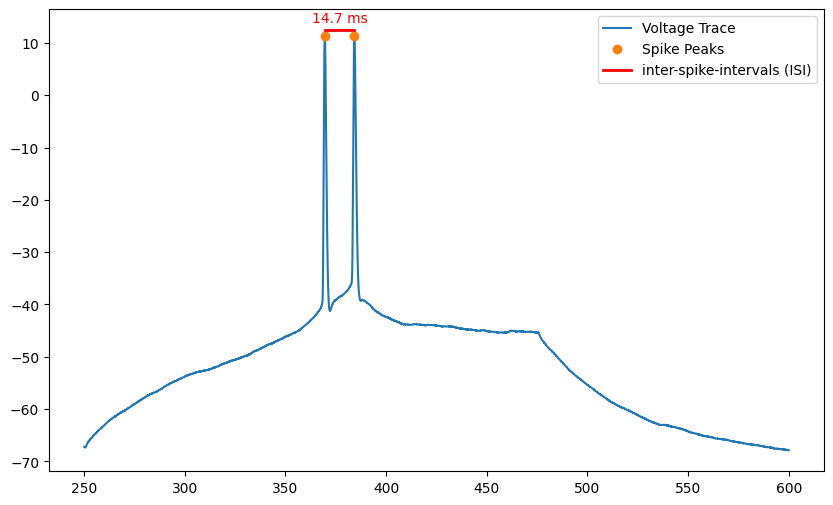

In [39]:
peak_times = feature_values['peak_time']
ap_heights = feature_values['AP_height']
all_isi_values = feature_values['all_ISI_values']

time_spike_indices = numpy.where((time > 250) & (time < 600))
time_spike = time[time_spike_indices]
voltage_spike = voltage[time_spike_indices]

plt.figure(figsize=(10, 6))
plt.plot(time_spike, voltage_spike, label='Voltage Trace')
plt.plot(peak_times, ap_heights, 'o', label='Spike Peaks')

for i in range(len(peak_times) - 1):
        start_spike_time = peak_times[i]
        end_spike_time = peak_times[i + 1]
        duration = round(all_isi_values[i], 2)
        y_position = max(ap_heights[i], ap_heights[i + 1]) + 1
        if i == 0:
            plt.plot([start_spike_time, end_spike_time], [y_position, y_position], 'r-', lw=2, label='inter-spike-intervals (ISI)')
        else:
            plt.plot([start_spike_time, end_spike_time], [y_position, y_position], 'r-', lw=2)

        midpoint = (start_spike_time + end_spike_time) / 2
        plt.text(midpoint, y_position + 1, f'{duration} ms', verticalalignment='bottom', horizontalalignment='center', color='red')

plt.legend()
plt.show()